# GEODOS data processing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [2]:
dto = '/storage/stations/LS/GEODOS/2023/03/27/'
dto = '/storage/stations/LS/GEODOS/2023/05/30/'


df = pd.DataFrame()
  
for fto in glob.iglob(dto + '*'): # generator, search immediate subdirectories 
    print(fto)
    l=[]
    l.extend(range(0,1039))
    rdf = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='c',low_memory=False)
    df = pd.concat([df, rdf])
    
    
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)


/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_10
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_03
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_09
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_04
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_17
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_13
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_19
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_00
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_07
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_14
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_16
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_05
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_08
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_02
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_11
/storage/stations/LS/GEODOS/2023/05/30/g

In [3]:
START_HIST = 12 # Sloupec prvniho kanalu HIST
FIRST_CH = 17  # Sloupec prvniho kanalu bez sumu
LAST_CH = 36+1 # Sloupec posledni kanalu HIST

hist = df.loc[df[1]=='$HIST'].iloc[:,FIRST_CH:LAST_CH]
hist['time'] = df.loc[df[1]=='$HIST'].iloc[:,0]
hist['time'] = pd.to_datetime(hist['time'], unit='s')

hist['temperature'] = df.loc[df[1]=='$HIST'].iloc[:,6]
hist['pressure'] = df.loc[df[1]=='$HIST'].iloc[:,5]
hist['voltage'] = df.loc[df[1]=='$HIST'].iloc[:,7]
hist['current'] = df.loc[df[1]=='$HIST'].iloc[:,8]

#hist.set_index('time', drop=False, inplace=True)


## Add individual events to histogram

In [4]:
hits = df.loc[df[1]=='$HITS'].copy()
hits.iloc[:,2:] = hits.iloc[:,2:].apply(pd.to_numeric)
hits['time'] = df.loc[df[1]=='$HITS'].iloc[:,0]
hits['time'] = pd.to_datetime(hits['time'], unit='s')
#hits.set_index('time', inplace=True)


In [5]:
histogram = pd.DataFrame(np.zeros((len(hits), 1100)))
hist.reset_index(drop=True,inplace=True)
histogram.iloc[:,0:LAST_CH-FIRST_CH] = hist.iloc[:,0:LAST_CH-FIRST_CH]

for i in range(len(hits)):
    for j in range(hits.iloc[i,2]):
        histogram.iloc[i,int(hits.iloc[i,j*2+4]-(FIRST_CH-START_HIST))] +=1

histogram['temperature'] = hist['temperature'].apply(pd.to_numeric)
histogram['pressure'] = hist['pressure'].apply(pd.to_numeric)
histogram['voltage'] = hist['voltage'].apply(pd.to_numeric)
histogram['current'] = hist['current'].apply(pd.to_numeric)

histogram['time'] = hist['time']
histogram.set_index('time', drop=False, inplace=True);


In [6]:
histogram['temperature'] = hist['temperature'].apply(pd.to_numeric)


## Plot Flux

<AxesSubplot:xlabel='time', ylabel='Counts'>

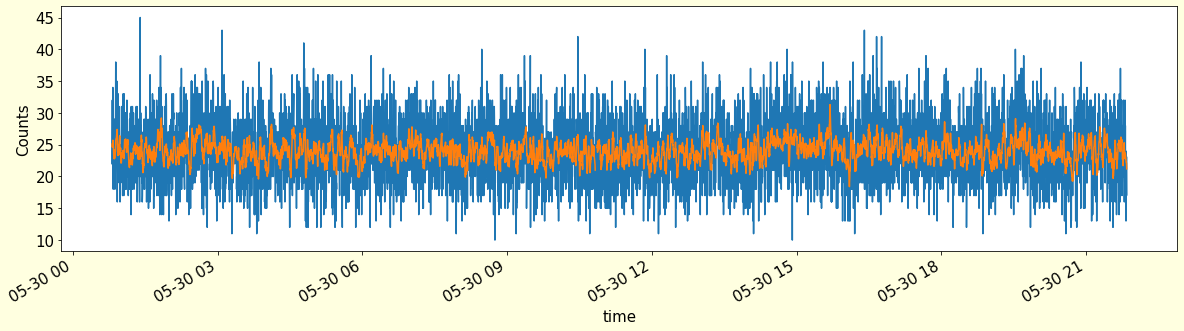

In [7]:
histogram['flux'] = histogram.loc[:,0:1024].sum(axis=1)

plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

histogram['roll'] = histogram['flux'].rolling(10).mean()

plt.ylabel('Counts')

histogram['flux'].plot()
histogram['roll'].plot()

## Plot Energy

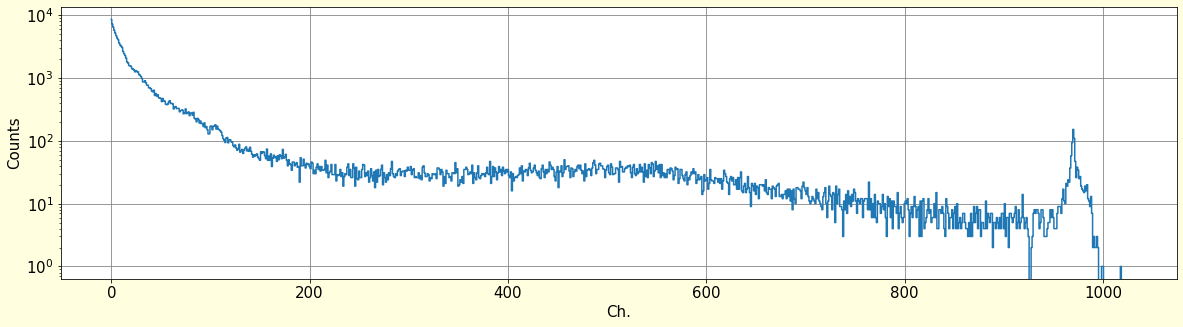

In [8]:
yy = histogram.copy()
#yy = yy.loc['2023-03-27 11:00:00':'2023-03-27 13:00:00']
ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()

plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

plt.plot(ener[0], drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([10,100])

## Plot Detail

/tmp/ipykernel_15101/801694926.py:8: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  histogram.loc[FROM:TO,'flux'].plot()
/tmp/ipykernel_15101/801694926.py:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  histogram.loc[FROM:TO,'roll'].plot()


<AxesSubplot:xlabel='time'>

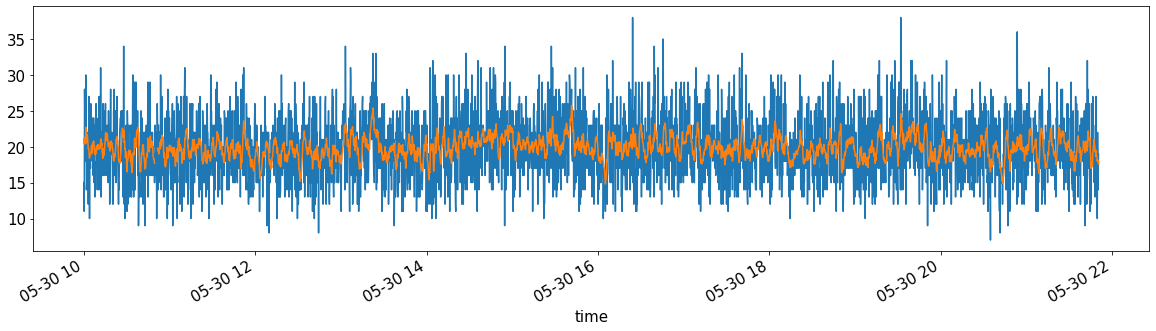

In [27]:
FROM = '2023-05-30 10:00'
TO = '2023-05-30 22:00'
histogram['flux'] = histogram.loc[:,0:100].sum(axis=1)
histogram['roll'] = histogram['flux'].rolling(10).mean()
plt.figure(figsize=(20,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})
histogram.loc[FROM:TO,'flux'].plot()
histogram.loc[FROM:TO,'roll'].plot()

In [ ]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

FROM = '2021-08-15 18:04:00' 
TO = '2021-08-15 19:00:00'
yy = yy.loc[FROM:TO]
plt.figure(figsize=(20,5), facecolor='lightyellow')

#orig_map=plt.cm.get_cmap('gnuplot2')
#reversed_map = orig_map.reversed()

plt.imshow( yy.iloc[:,11:18].T, aspect='auto', origin='lower', cmap = 'gnuplot2')#, norm=colors.LogNorm()) # , cmap = 'autumn') 
plt.ylabel('Energy [keV]')
plt.xlabel('UTC')
plt.colorbar(label='Counts [-]')
x1 = [0,20,40,60,80]
squad = [str(yy.iloc[0].UTC.round(freq='S')),str(yy.iloc[20].UTC.round(freq='S')),str(yy.iloc[40].UTC.round(freq='S')),str(yy.iloc[60].UTC.round(freq='S')),str(yy.iloc[80].UTC.round(freq='S'))]
plt.xticks(x1, squad, rotation=90)

y1 = list(range(0,7))
y2 = ['']*7
for i in range(len(y1)):  
    y2[i] = str(round(113.2*y1[i]+473.46))
plt.yticks(y1, y2, rotation=0)
None


# Telemetry Plot

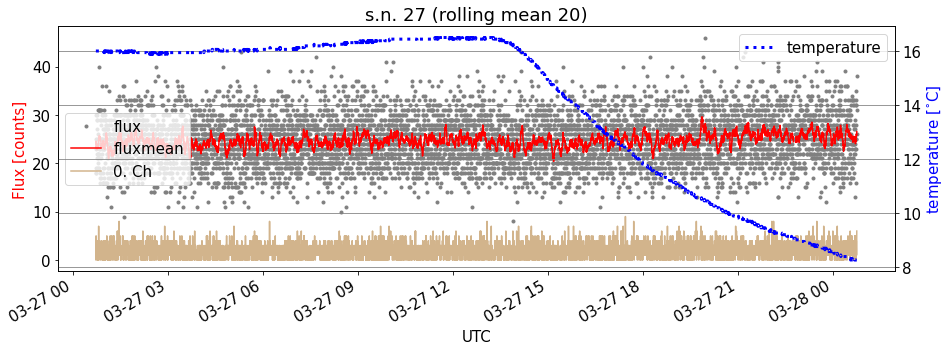

In [174]:
NOISE_LEVEL = 0
LAST_CHANNEL = 1024
WINDOW = 20

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('time', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00'] # bourka s odpalenu dobijeci eletronikou

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=6)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')
plt.legend()



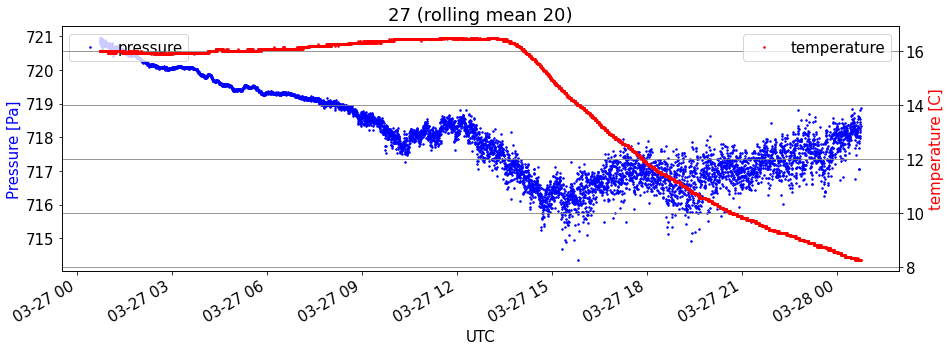

In [171]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('time', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx['pressure'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')
plt.legend()



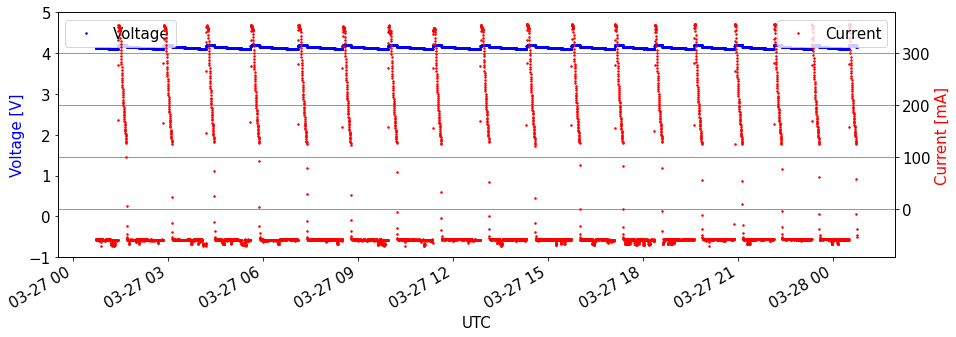

In [173]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('time', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
#xx = xx.loc['2021-08-15 00:00:00':'2021-08-16 00:00:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']



xx['voltage'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'Voltage')

s = fto.split('/')
#plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([-1,5])
plt.xlabel('UTC')
plt.ylabel(r'Voltage [V]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['current'].plot(c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('Current [mA]', color='red')

plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')
plt.legend()



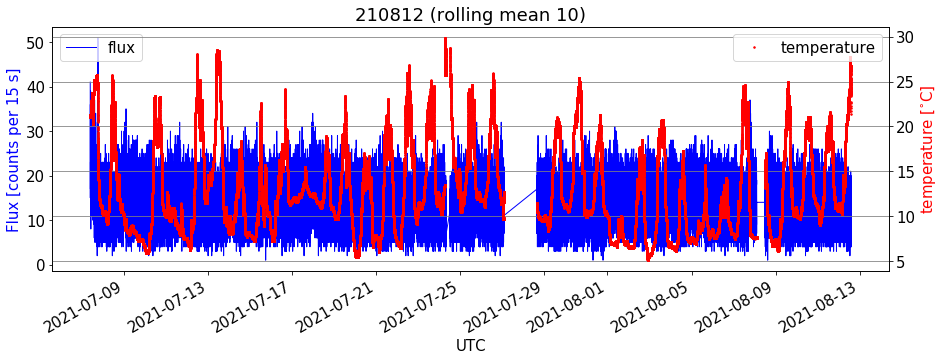

In [22]:
NOISE_LEVEL = 0
LAST_CHANNEL = 240
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

#xx['flux'].plot(c='gray', marker='.', linewidth=1)
xx['flux'].plot(c='blue', linewidth=1)
#xx['fluxmean'].plot(c='red')
#(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts per 15 s]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



# Blitzortung

In [15]:
lat=49.0640992 # Polednik
lon=13.3950208

#lat=49.05367 # Prvni strom
#lon=13.40039

#start=pd.Timestamp('2021-08-15 12:00') # bourke kdy odesla dobijeci elektronika
#end=pd.Timestamp('2021-08-16 18:00')

start=pd.Timestamp('2021-07-08 00:00') # bourka kdy odesla dobijeci elektronika
end=pd.Timestamp('2021-08-13 00:00')

BLITZ_DIST = 60

print(start, end, lat, lon)
region=1

### url for json data preparation
url=[]

for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

import requests
blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        html = requests.get(url[i]).content
        blitz_part = pd.read_json(html,lines=True)
        blitz_part.drop(columns=['status','sig','mds','mcg'], inplace=True)#,'region', 
        blitz=blitz.append(blitz_part)
    except:
        print("No data", url[i])
        pass
blitz.set_index(['time'], inplace=True)

### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-2) )&(blitz['lat']<(lat+2) )]
blitz=blitz[(blitz['lon']>(lon-3.5) )&(blitz['lon']<(lon+3.5) )]

### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees
try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
    pass
#blitz['time']=blitz.index    
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)

blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)
try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
blitz = blitz.loc[blitz['km'] < BLITZ_DIST]
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
#blitz.reset_index(inplace=True)
#blitz.set_index('date', inplace=True)

blitz.to_csv(dto + "/blitz.csv")

print('end')

2021-07-08 00:00:00 2021-08-13 00:00:00 49.0640992 13.3950208
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/20.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/30.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/40.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/50.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/00.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/10.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/20.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/30.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/40.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/50.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/21/00.json
No data http:/

In [16]:
blitz

,time,lat,lon,km,date
date,,,,,
2021-07-08 00:48:30.829185439,1625705310829185439,48.632866,13.240356,49.322458,2021-07-08 00:48:30.829185439
2021-07-08 00:48:30.831775957,1625705310831775957,48.653590,13.260290,46.749865,2021-07-08 00:48:30.831775957
2021-07-08 00:48:30.831781386,1625705310831781386,48.652350,13.263133,46.841445,2021-07-08 00:48:30.831781386
2021-07-08 00:48:30.831782609,1625705310831782609,48.643393,13.253908,47.958762,2021-07-08 00:48:30.831782609
2021-07-08 11:56:00.228902204,1625745360228902204,48.957762,12.619286,57.863355,2021-07-08 11:56:00.228902204
...,...,...,...,...,...
2021-08-08 14:43:05.345944478,1628433785345944478,49.431200,13.125008,45.330898,2021-08-08 14:43:05.345944478
2021-08-08 14:43:05.345913004,1628433785345913004,49.539735,13.026111,59.332627,2021-08-08 14:43:05.345913004
2021-08-08 14:43:05.345945476,1628433785345945476,49.439992,13.117333,46.453850,2021-08-08 14:43:05.345945476


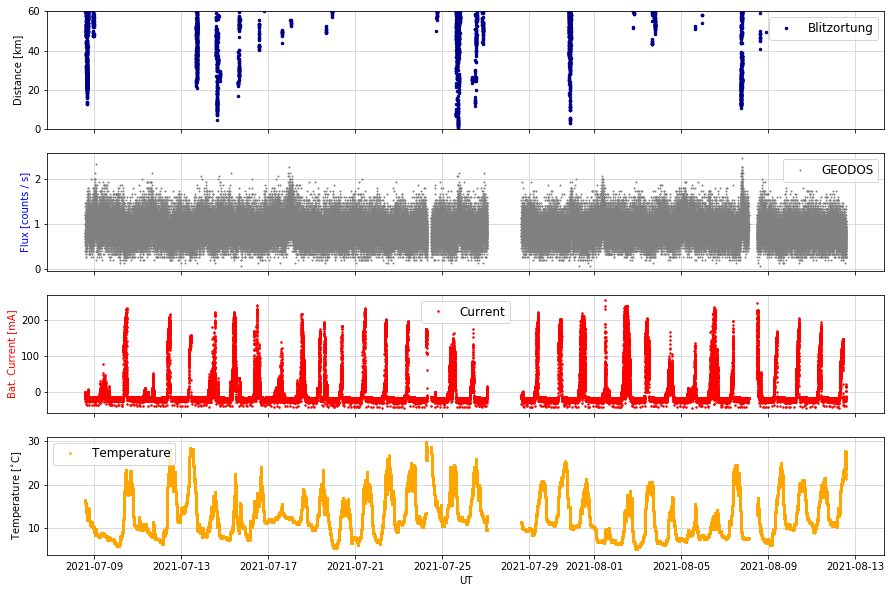

In [30]:
WINDOW = 2

blitz = pd.read_csv(dto + "/blitz.csv")
blitz['date'] = pd.to_datetime(blitz['date'])
blitz.set_index('date', inplace=True)

fig, (ax6, ax3, ax5, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(15,10))
matplotlib.rcParams.update({'font.size': 12})

FROM = '2021-07-08 14:00:00'
TO = '2021-08-16 18:15:00'
#FROM = '2021-08-15 12:00:00'
#TO = '2021-08-16 18:00:00'
#FROM = '2021-08-15 18:00:00'
#TO = '2021-08-15 19:00:00'
#FROM = '2021-08-16 9:00:00'
#TO = '2021-08-16 12:00:00'

xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00'] # bourka s odpalenou elektronikou
#xx = xx.loc['2021-08-15 18:00:00':'2021-08-15 19:00:00'] # bourka s odpalenou elektronikou
#xx = xx.loc['2021-08-16 9:00:00':'2021-08-16 12:00:00'] # bourka s odpalenou elektronikou
#xx = xx.loc['2021-08-15 18:00:00':'2021-08-16 18:15:00']



xx = xx.loc[FROM:TO]
lightning = blitz.loc[FROM:TO]

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

ax3.plot(xx['flux']/15, marker='.', color='gray', label='GEODOS', ms=2, linestyle='none')
#ax3.plot(xx['fluxmean']/15, label='mean')
ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax3.set_ylabel(r'Flux [counts / s]', color='blue')
#ax3.set_yscale('log')
#ax3.set_ylim(.6,2.5)
ax3.legend(loc=1)


ax4.plot(xx['temperature'], c='orange', label='Temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax4.set_xlabel('UT')
ax4.set_ylabel(r'Temperature [$^{\circ}$C]')
ax4.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax4.legend()

ax6.plot(lightning.index, lightning.km, ls='', marker='.', ms=5, label='Blitzortung', c='darkblue')
ax6.set_ylabel('Distance [km]')
ax6.legend()
ax6.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax6.set_ylim(0,60)

ax5.plot(xx['current'], c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax5.set_ylabel('Bat. Current [mA]', color='red')
ax5.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax5.legend()


In [20]:
xx

,0,1,2,3,4,5,6,7,8,9,...,lat,lon,date,UTC,temperature,pressure,voltage,current,flux,fluxmean
UTC,,,,,,,,,,,,,,,,,,,,,
2021-08-15 18:00:06.550,2.0,3,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:00:06.550,16.94,86737.50,4.08,-65,12.0,NaN
2021-08-15 18:00:22.420,5.0,3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:00:22.420,16.88,86747.50,4.08,-65,14.0,13.0
2021-08-15 18:00:38.600,4.0,4,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:00:38.600,16.88,86737.75,4.08,-65,15.0,14.5
2021-08-15 18:00:54.770,2.0,1,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:00:54.770,16.81,86754.75,4.08,-65,10.0,12.5
2021-08-15 18:01:10.960,1.0,3,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:01:10.960,16.81,86747.50,4.08,-65,11.0,10.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-15 18:58:48.140,3.0,3,2.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:58:48.140,15.81,86661.75,-0.26,-257,20.0,16.0
2021-08-15 18:59:04.300,3.0,2,2.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:59:04.300,15.81,86654.75,-0.26,-257,14.0,17.0
2021-08-15 18:59:20.470,3.0,6,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:59:20.470,15.88,86653.00,-0.26,-257,17.0,15.5


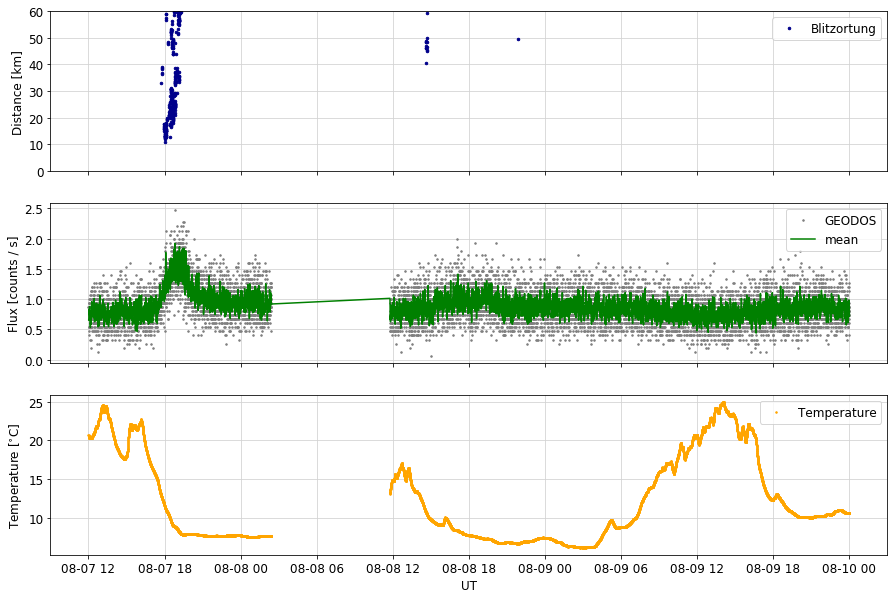

In [72]:
WINDOW = 5

blitz = pd.read_csv(dto + "/blitz.csv")
blitz['date'] = pd.to_datetime(blitz['date'])
blitz.set_index('date', inplace=True)

fig, (ax6, ax3, ax4) = plt.subplots(nrows=3, sharex=True, figsize=(15,10))
matplotlib.rcParams.update({'font.size': 12})

FROM = '2021-07-08 12:00:00'
TO = '2021-08-16 18:15:00'
#FROM = '2021-07-30 12:00:00'
#TO = '2021-08-2 12:00:00'
FROM = '2021-08-7 12:00:00'
TO = '2021-08-10 00:00:00'
#FROM = '2021-07-25 12:00:00'
#TO = '2021-07-26 12:00:00'

xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
xx = xx.loc[FROM:TO]
lightning = blitz.loc[FROM:TO]

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

ax3.plot(xx['flux']/15, marker='.', color='gray', label='GEODOS', ms=3, linestyle='none')
ax3.plot(xx['fluxmean']/15, label='mean', color='green')
ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax3.set_ylabel(r'Flux [counts / s]')
#ax3.set_yscale('log')
#ax3.set_ylim(.5,2.2)
ax3.legend()
#ax3.set_xlabel('UT')

ax4.plot(xx['temperature'], c='orange', label='Temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax4.set_xlabel('UT')
ax4.set_ylabel(r'Temperature [$^{\circ}$C]')
ax4.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax4.legend()

ax6.plot(lightning.index, lightning.km, ls='', marker='.', ms=5, label='Blitzortung', c='darkblue')
ax6.set_ylabel('Distance [km]')
ax6.legend()
ax6.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax6.set_ylim(0,60)

ax5.plot(xx['current'], c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax5.set_ylabel('Bat. Current [mA]', color='red')
ax5.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax5.legend()


# Energy Spectrum

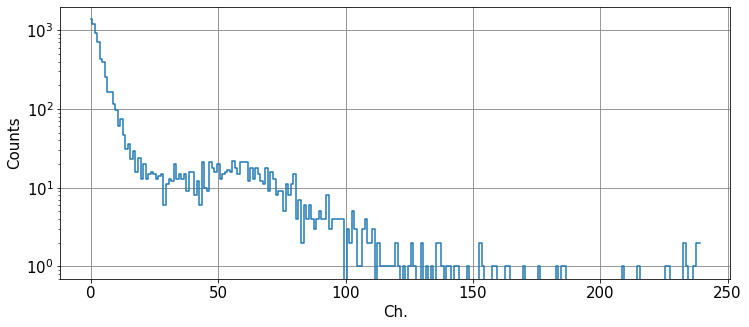

In [41]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)
#yy = yy.loc['2021-08-15 11:00:00':'2021-08-16 18:00:00']
yy = yy.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,0:240].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([10,100])

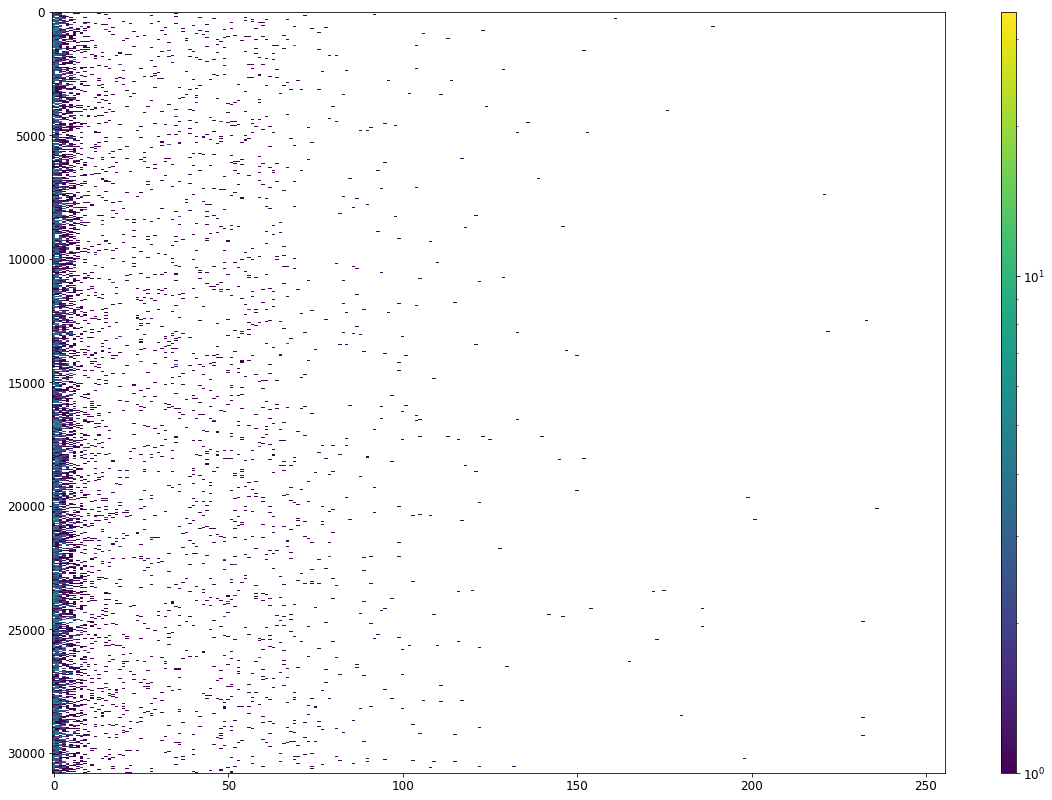

In [33]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 14))
plt.imshow((histogram.iloc[:,0:256]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
None

## Resetitko LS

In [86]:
dto = '/storage/stations/LS/resetitko/2023/03/27/'

df = pd.DataFrame()
  
for fto in glob.iglob(dto + '*'): # generator, search immediate subdirectories 
    print(fto)
    l=[]
    l.extend(range(0,100))
    #rdf = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='c')
    rdf = pd.read_table(fto, sep=',', header=None, comment='*',engine='c')
    df = pd.concat([df, rdf])
    
    
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)


/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_16
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_05
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_08
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_02
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_23
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_11
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_15
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_06
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_01
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_20
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_18
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_12
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_22
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_10
/storage/stations/LS

In [87]:
df

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,1679935084,$CANDY,57741,628546,52100,0,254,0,9454,27098,...,0,0,0,0,0,0,0,0,0,0
1,1679935095,$CANDY,57742,628557,52088,0,254,0,9588,26850,...,0,0,0,0,0,0,0,0,0,0
2,1679935105,$CANDY,57743,628568,52140,1,254,0,9461,26892,...,0,0,0,0,0,0,0,0,0,0
3,1679935116,$CANDY,57744,628579,52140,0,255,0,9435,26980,...,0,0,0,0,0,0,0,0,0,0
4,1679935127,$CANDY,57745,628589,52079,0,255,0,9605,26793,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,1679931426,$CANDY,57405,624888,51997,1,253,0,9253,27072,...,0,0,0,0,0,0,0,0,0,0
327,1679931437,$CANDY,57406,624899,52057,1,254,0,8993,27335,...,0,0,0,0,0,0,0,0,0,0
328,1679931448,$CANDY,57407,624910,52033,1,255,0,8907,27383,...,0,0,0,0,0,0,0,0,0,0
329,1679931459,$CANDY,57408,624921,52045,3,254,0,9134,27220,...,0,0,0,0,0,0,0,0,0,0


In [96]:
hist = df.loc[df[1]=='$CANDY'].iloc[:,12:]
hist['time'] = df.loc[df[1]=='$CANDY'].iloc[:,0]
hist['time'] = pd.to_datetime(hist['time'], unit='s')
hist.set_index('time', drop=False, inplace=True)
hist['flux'] = hist.loc[:,17:36].sum(axis=1)


<AxesSubplot:xlabel='time', ylabel='Counts'>

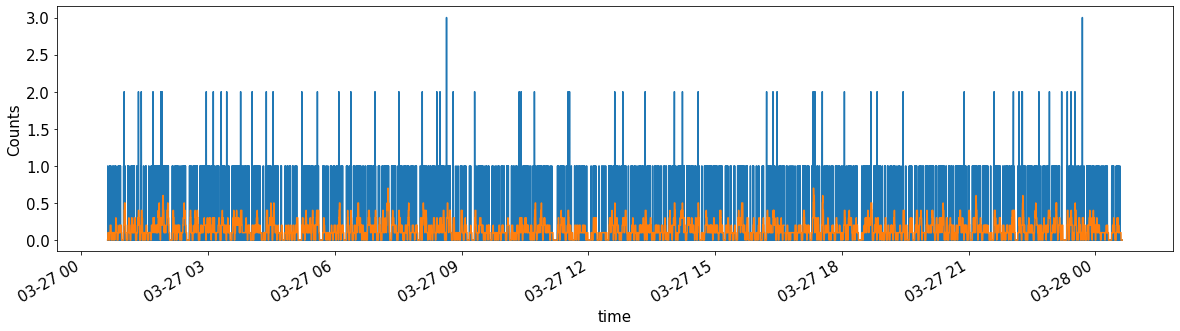

In [98]:
plt.figure(figsize=(20,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

hist['roll'] = hist['flux'].rolling(10).mean()

plt.ylabel('Counts')

hist['flux'].plot()
hist['roll'].plot()

/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_21
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_19
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_13
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_00
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_07
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_14
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_22
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_10
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_09
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_03
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_04
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_17
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_15
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_06
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_01
/storage/stations/LS/vezi

/tmp/ipykernel_15101/1123750235.py:48: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  histogram.loc[FROM:TO,'flux'].plot(alpha=0.5,color='lightgray')
/tmp/ipykernel_15101/1123750235.py:49: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  histogram.loc[FROM:TO,'roll'].plot(alpha=0.5,color='orange')


<AxesSubplot:xlabel='time'>

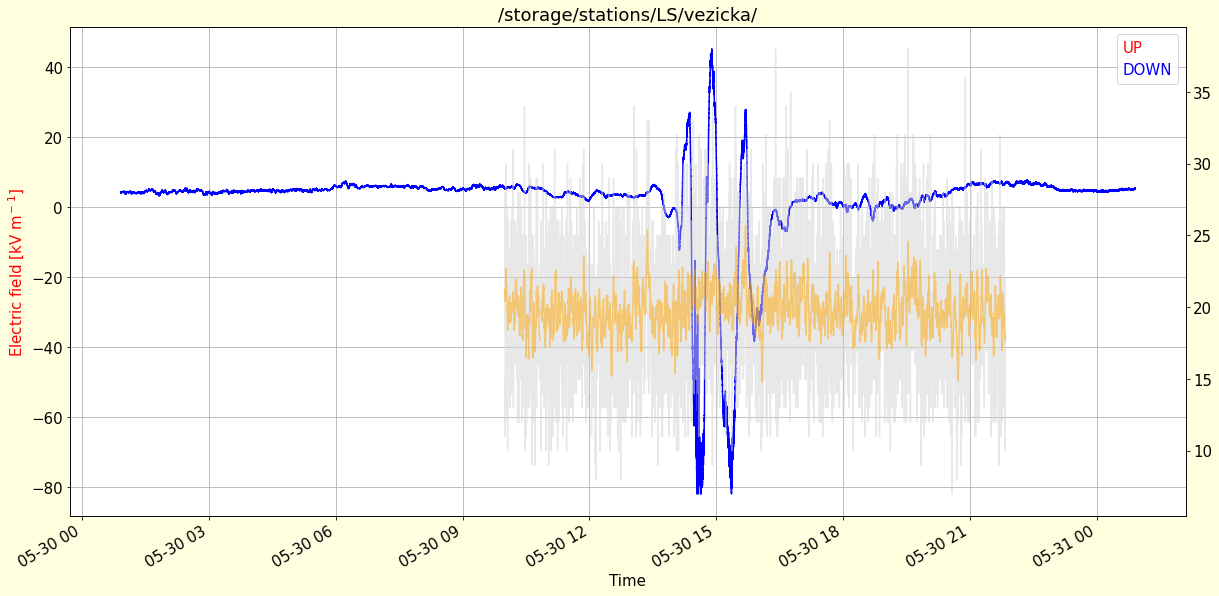

In [36]:
fto = '/storage/stations/LS/vezicka/'

ftt = glob.iglob(fto+"/**/*down*.csv.2023-05-30*") # generator, search immediate subdirectories 

plt.figure(figsize=(20,10), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})

for f in ftt:
    print(f)
    l=[]
    l.extend(range(0,4))
    
    df = pd.read_csv(f, sep=',', header=None, names=l, comment='*', low_memory=False, on_bad_lines='skip')

    if 'up' in f:
        label = 'UP'
        color = 'red'
        factor = 1
    else:
        label = 'DOWN'
        color = 'blue'
        factor = 4
   
    
    df['field'] = df[1].str.replace('$', '', regex=False)
    df['time'] = pd.to_datetime(df[0],unit='s')
    df.set_index('time', inplace=True, drop=False)
    df['field'] = pd.to_numeric(df['field'])
    
    (df['field']*factor).plot(label=label, color=color)

plt.ylabel('Electric field [kV m$^-$$^1$]', color='red')
plt.title(fto)
#plt.legend()
plt.legend(['UP','DOWN'], labelcolor=['red','blue'], handlelength=0, handletextpad=0, fancybox=True) 
plt.grid()
plt.xlabel('Time')
#plt.ylim(-20,20)
#plt.xlim('2023-05-29 21:00','2023-05-29 23:59')

plt.twinx()

FROM = '2023-05-30 10:00'
TO = '2023-05-30 22:00'
histogram['flux'] = histogram.loc[:,0:100].sum(axis=1)
histogram['roll'] = histogram['flux'].rolling(10).mean()
matplotlib.rcParams.update({'font.size': 15})
histogram.loc[FROM:TO,'flux'].plot(alpha=0.5,color='lightgray')
histogram.loc[FROM:TO,'roll'].plot(alpha=0.5,color='orange')